(481, 321)


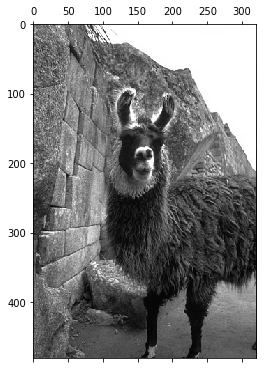

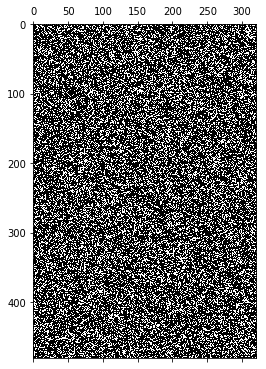

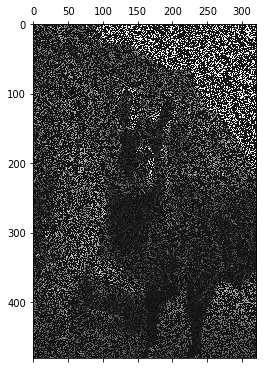

In [3]:
import numpy as np
from numpy.linalg import matrix_rank as rank
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray

path = "/home/sircrashalot/Schreibtisch/Mathematik/Master/S03/compressed sensing/project/training_set/03inpainting/03Inpainting/data/BSDS500/6046.jpg"

# load the image
image = Image.open(path).convert('L')
# convert image to numpy array
image = asarray(image)
m,n = image.shape


def lowrank_missing(image, p, k, noise=0.0):
    """
    Generates an image A' where we have the rank k and missing entries.
    The given entries have optional noise.
    
    Input:
        A : the image we wish to corrupt
        p : the probability that a given entry is missing in the final image
        k : the rank of the final corrupted image
        noise : the additive noise factor for our given entries. We assume that 
                our noise satisfies the normal distribution N(0,noise).
    """

    
    m, n = image.shape
    #print(m,n)
    mask = np.random.choice(np.arange(0,2), p=[p, 1-p], size=(m,n))
    noise_matrix = np.random.normal(loc=0, scale = noise, size=(m,n))
    
    image_masked = np.multiply(image + noise_matrix,mask)
    U, s, VT = np.linalg.svd(image_masked, full_matrices=True )
    r = rank(image_masked)
    s[n-k:] = 0
    #print(s)
    S = np.zeros((m, n), dtype=np.float)
    S[:n, :n] = np.diag(s)
    mask_rec = U@(S@VT)
    return (mask_rec, mask)
                        
                        
                        
k = 33
prob = 0.7          
image_noisy, mask = lowrank_missing(image, prob, k)

print(image.shape)

plt.matshow(image, cmap="gray")
plt.matshow(mask, cmap="gray")
plt.matshow(image_noisy, cmap="gray")


### Image reconstruction in the noiseless case via DRS

We are trying to solve the minimization problem $$\min_X ||X||_* \ \ \ s. t. \ \ \ AX = B$$
This can be done via Douglas-Rachford splitting. For a derivation see the report.
\begin{align}
y^{(k)} &= 2(z^{(k)} + A^T(B - Az^{(k)})) - z^{(k)}\\
z^{(k+1)} &= z^{(k)} + \mathcal{D}_\gamma(y^{(k)}) - \mathcal{D}_\gamma(z^{(k)})
\end{align}

-23.497832162057893


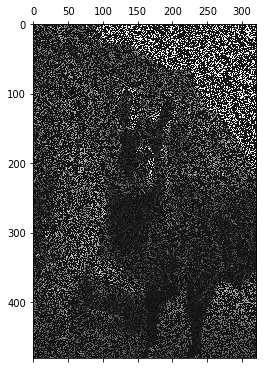

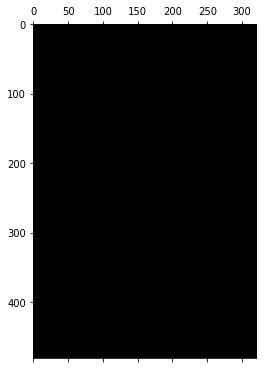

In [21]:
from scipy.sparse import csc_matrix

def D(X, gamma, m, n):
    """
    The singular value thresholding operator
    """
    X_ = X.reshape((m,n))
    U, s, VT = np.linalg.svd(X_, full_matrices=True)
    #print(s.shape, "ssss", type(s), type(s-gamma))
    st = np.maximum(0, s - gamma)
    S = np.zeros((m, n), dtype=np.float)
    S[:n, :n] = np.diag(st)
    Xt = U@(S@VT)
    Xt = Xt.reshape(m*n)
    return Xt


def draw(vec):
    mat = vec.reshape((m,n))
    plt.matshow(mat, cmap="gray")

def flatten(omega):
    """
    Transform the index set omega ( which stores the elements which are nonzero in the corrupted image )
    to a vector-index representation. 
    """
    global n
    flattened = []
    for coord in omega:
        i,j = coord
        #print(i,j, n, m, i*n + j)
        flattened.append(i*n + j)
    return flattened
    
def construct_A(m, n, omega, Y, B):
    """
    Construct the 
    """
    omega_flat = flatten(omega)
    
    row = np.arange(m*n)
    col = np.arange(m*n)
    data = np.ones(m*n)

    for i in range(0, len(omega_flat)):
        data[omega_flat[i]] = B[i] / Y[i] 
    A = csc_matrix((data, (row, col)), shape=(m*n, m*n))
    return A


omega = np.argwhere(mask!=0)
B = image_noisy.reshape(m*n)



draw(B)
def DRS(iterations, gamma):
    zk = B
    
    for k in range(0, iterations):
        A = construct_A(m, n, omega, zk, B)
        xk = zk + A.T @ (B - A@zk)
        yk = D(2*xk - zk, gamma, m, n)
        zk = zk + yk - xk
    return zk

rec = DRS(3, gamma = .006)
print(rec.min())
draw(rec)

In [75]:
r = np.arange(0,12)
print(r)

r.reshape(3,4)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])